In [66]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import norm 

In [67]:
# Convertible bond pricing model (Cox-Ross-Rubinstein method)
def CRR_convertible_bond(S0, F, T, r, k, coupon, conversion_ratio, steps, AmeEur='e'):
    dt = T / steps                      # Time step
    u = np.exp(sigma * np.sqrt(dt))     # Up factor
    d = 1 / u                           # Down factor
    p = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability

    # Create the binomial stock price tree
    stock_price_tree = np.zeros((steps + 1, steps + 1))
    for i in range(steps + 1):
        for j in range(i + 1):
            stock_price_tree[j, i] = S0 * (u ** j) * (d ** (i - j))

    # Create the bond price tree (including coupon payments)
    bond_price_tree = np.zeros((steps + 1, steps + 1))
    # Create the conversion probability tree
    conversion_prob_tree = np.zeros((steps + 1, steps + 1))

    # Calculate bond prices and conversion probabilities at maturity
    for j in range(steps + 1):
        stock_price = stock_price_tree[j, steps]
        bond_value_at_maturity = max(conversion_ratio * stock_price, F + coupon)
        bond_price_tree[j, steps] = bond_value_at_maturity
        # Conversion probability is 1 if conversion is optimal at maturity
        conversion_prob_tree[j, steps] = 1 if conversion_ratio * stock_price > F + coupon else 0

    # Initialize coupon timing and time management
    CouponTime = T  # Initial coupon time matches maturity

    # Backward calculation for bond price and conversion probability
    for i in range(steps - 1, -1, -1):
        if CouponTime != (T - np.ceil((steps - i + 1) * dt)):
            CouponPayment = 1  # It's time to pay a coupon
            CouponTime = T - np.ceil((steps - i) * dt)
            Time = CouponTime - dt * i
        else:
            CouponPayment = 0

        for j in range(i + 1):
            stock_price = stock_price_tree[j, i]

            # Dynamic discount factors (ru, rd)
            ru = conversion_prob_tree[j+1, i+1] * r + (1 - conversion_prob_tree[j+1, i+1]) * (r + k)
            rd = conversion_prob_tree[j, i+1] * r + (1 - conversion_prob_tree[j, i+1]) * (r + k)

            if CouponPayment == 1:
                CouponValue = coupon * (p * np.exp(-ru * Time) + (1 - p) * np.exp(-rd * Time))
            else:
                CouponValue = 0

            # Calculate bond price using backward induction
            hold_bond_value = CouponValue + p * bond_price_tree[j + 1, i + 1] * np.exp(-ru * dt) + (1 - p) * bond_price_tree[j, i + 1] * np.exp(-rd * dt)
            convert_to_stock_value = conversion_ratio * stock_price

            # Bond price is the maximum of holding or converting
            bond_price_tree[j, i] = max(hold_bond_value, convert_to_stock_value)

            # Conversion probability: set to 1 if conversion happens, otherwise average the next nodes
            if bond_price_tree[j, i] == convert_to_stock_value:
                conversion_prob_tree[j, i] = 1
            else:
                conversion_prob_tree[j, i] = p * conversion_prob_tree[j + 1, i + 1] + (1 - p) * conversion_prob_tree[j, i + 1]

    return stock_price_tree, bond_price_tree, conversion_prob_tree

In [68]:
# Function to plot the binomial tree
def plot_binomial_tree(tree, title):
    steps = tree.shape[1] - 1
    G = nx.DiGraph()

    pos = {}
    labels = {}
    
    # Define the horizontal offset to center the nodes at each level
    for i in range(steps + 1):
        for j in range(i + 1):
            node = f"{i},{j}"
            G.add_node(node)
            pos[node] = (i, j - (i / 2))  # Adjust vertical position to center the tree
            labels[node] = f"{tree[j, i]:.2f}"

            if i < steps:
                G.add_edge(node, f"{i+1},{j}")
                G.add_edge(node, f"{i+1},{j+1}")

    # Plot
    plt.figure(figsize=(12, 6))
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", edge_color="black")
    plt.title(title)
    plt.show()

In [69]:
# Parameters
S0 = 75                             # Initial stock price
F = 100                             # Face value of the bond
T = 5                               # Time to maturity (in years)
r = 0.07                            # Risk-free rate
k = 0.03                            # Credit spread
sigma = 0.2                         # Volatility
dt = 1
coupon = 6                          # Coupon payment per year
m = 1                               # Conversion ratio (1 bond = 1 stock)
steps = 5                           # Number of time steps

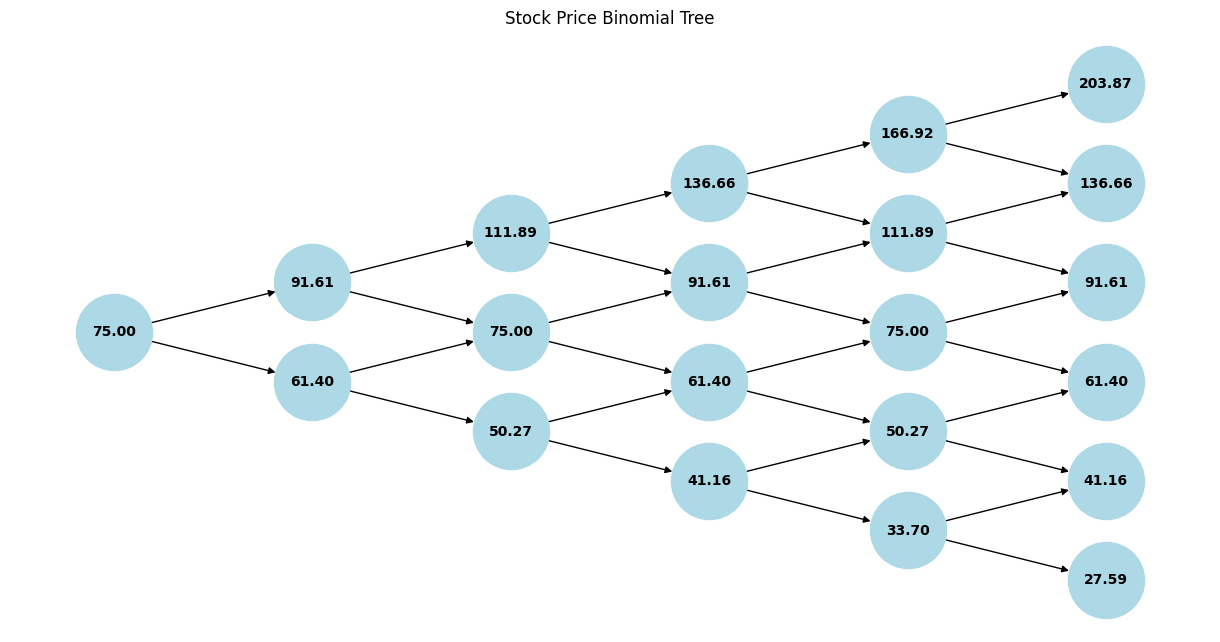

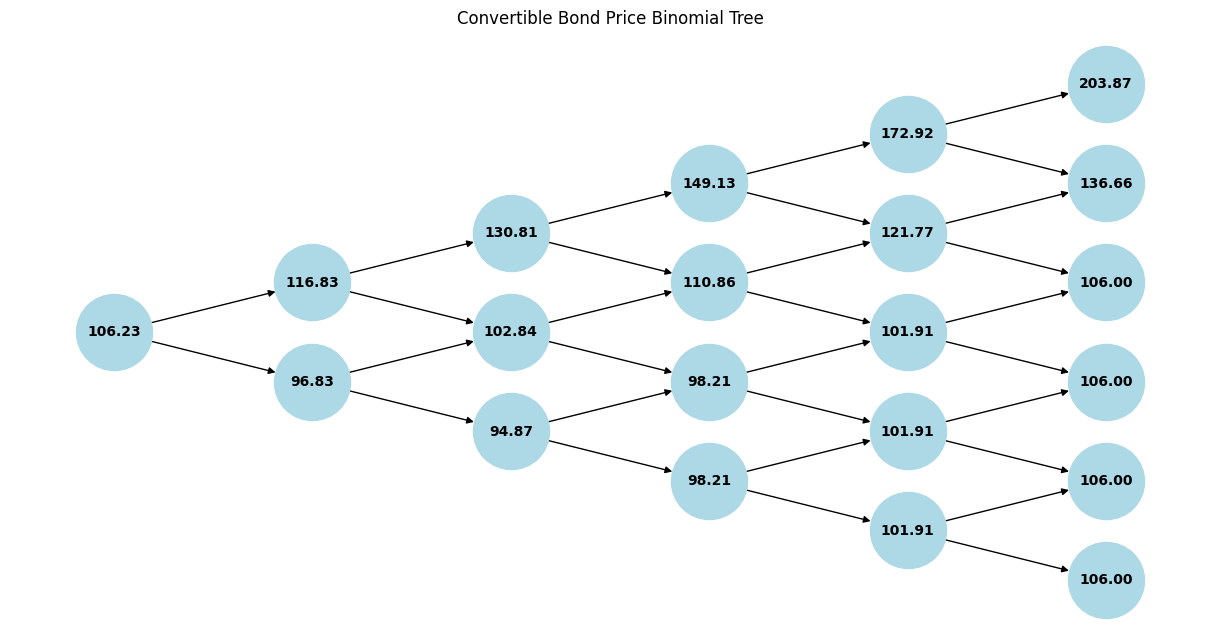

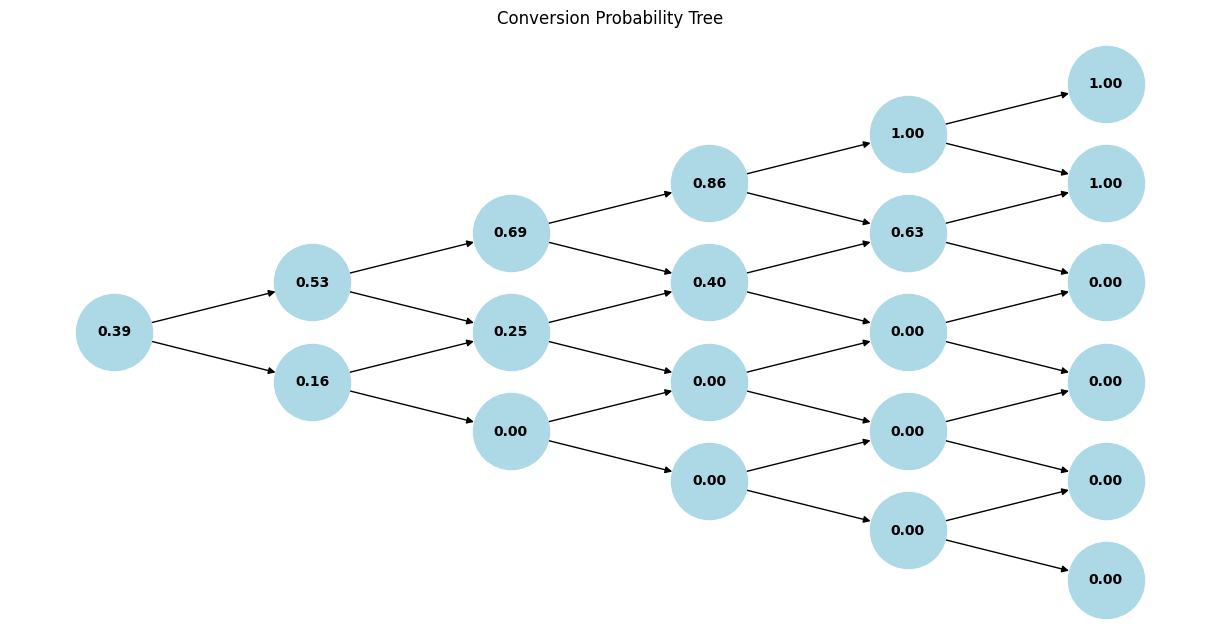

In [70]:
# Calculate the binomial trees
stock_price_tree, bond_price_tree, conversion_prob_tree = CRR_convertible_bond(S0, F, T, r, k, coupon, m, steps)

# Plot the stock price tree
plot_binomial_tree(stock_price_tree, "Stock Price Binomial Tree")

# Plot the bond price tree
plot_binomial_tree(bond_price_tree, "Convertible Bond Price Binomial Tree")

# Plot the conversion probability tree
plot_binomial_tree(conversion_prob_tree, "Conversion Probability Tree")

In [71]:
# Function to compute u, d, and p based on different tree models
def calculate_tree_params(TreeType, sigma, dt, r, S, F, T, steps, b=0):
    if TreeType == 'CRR':
        u = np.exp(sigma * np.sqrt(dt))
        d = 1 / u
        p = (np.exp(r * dt) - d) / (u - d)
    elif TreeType == 'Tian':
        eta = np.exp(dt * sigma ** 2)
        u = 0.5 * np.exp(r * dt) * eta * (eta + 1 + np.sqrt(eta ** 2 + 2 * eta - 3))
        d = 0.5 * np.exp(r * dt) * eta * (eta + 1 - np.sqrt(eta ** 2 + 2 * eta - 3))
        p = (np.exp(b * dt) - d) / (u - d)
    elif TreeType == 'JR':
        u = np.exp(((b) - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt))
        d = np.exp(((b) - sigma ** 2 / 2) * dt - sigma * np.sqrt(dt))
        p = (np.exp(b * dt) - d) / (u - d)
    elif TreeType == 'CRRdrift':
        eta = (np.log(F) - np.log(S)) / T
        u = np.exp(eta * dt + sigma * np.sqrt(dt))
        d = np.exp(eta * dt - sigma * np.sqrt(dt))
        p = (np.exp(b * dt) - d) / (u - d)
    elif TreeType == 'Haahtela':
        u = np.exp(np.sqrt(np.exp(sigma ** 2 * dt) - 1) + np.exp(b * dt) * dt)
        d = np.exp(-np.sqrt(np.exp(sigma ** 2 * dt) - 1) + np.exp(b * dt) * dt)
        p = (np.exp(b * dt) - d) / (u - d)
    else:
        raise ValueError("Invalid TreeType specified.")
    
    return u, d, p

In [72]:
# Convertible bond pricing model (Cox-Ross-Rubinstein method)
def CRR_convertible_bond(S0, F, T, r, k, coupon, conversion_ratio, steps, TreeType='CRR', AmeEur='e'):
    dt = T / steps  # Time step

    # Compute u, d, and p based on the specified tree type
    u, d, p = calculate_tree_params(TreeType, sigma, dt, r, S0, F, T, steps)

    # Create the binomial stock price tree
    stock_price_tree = np.zeros((steps + 1, steps + 1))
    for i in range(steps + 1):
        for j in range(i + 1):
            stock_price_tree[j, i] = S0 * (u ** j) * (d ** (i - j))

    # Create the bond price tree (including coupon payments)
    bond_price_tree = np.zeros((steps + 1, steps + 1))
    # Create the conversion probability tree
    conversion_prob_tree = np.zeros((steps + 1, steps + 1))

    # Calculate bond prices and conversion probabilities at maturity
    for j in range(steps + 1):
        stock_price = stock_price_tree[j, steps]
        bond_value_at_maturity = max(conversion_ratio * stock_price, F + coupon)
        bond_price_tree[j, steps] = bond_value_at_maturity
        # Conversion probability is 1 if conversion is optimal at maturity
        conversion_prob_tree[j, steps] = 1 if conversion_ratio * stock_price > F + coupon else 0

    # Backward calculation for bond price and conversion probability
    for i in range(steps - 1, -1, -1):
        for j in range(i + 1):
            stock_price = stock_price_tree[j, i]

            # Calculate bond price using backward induction
            hold_bond_value = coupon + p * bond_price_tree[j + 1, i + 1] * np.exp(-r * dt) + (1 - p) * bond_price_tree[j, i + 1] * np.exp(-r * dt)
            convert_to_stock_value = conversion_ratio * stock_price

            # Bond price is the maximum of holding or converting
            bond_price_tree[j, i] = max(hold_bond_value, convert_to_stock_value)

            # Conversion probability: set to 1 if conversion happens, otherwise average the next nodes
            if bond_price_tree[j, i] == convert_to_stock_value:
                conversion_prob_tree[j, i] = 1
            else:
                conversion_prob_tree[j, i] = p * conversion_prob_tree[j + 1, i + 1] + (1 - p) * conversion_prob_tree[j, i + 1]

    return stock_price_tree, bond_price_tree, conversion_prob_tree

In [73]:
# Function to plot the binomial tree
def plot_binomial_tree(tree, title):
    steps = tree.shape[1] - 1
    G = nx.DiGraph()

    pos = {}
    labels = {}

    for i in range(steps + 1):
        for j in range(i + 1):
            node = f"{i},{j}"
            G.add_node(node)
            pos[node] = (i, j - (i / 2))  # Adjust vertical position to center the tree
            labels[node] = f"{tree[j, i]:.2f}"

            if i < steps:
                G.add_edge(node, f"{i + 1},{j}")
                G.add_edge(node, f"{i + 1},{j + 1}")

    plt.figure(figsize=(12, 6))
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", edge_color="black")
    plt.title(title)
    plt.show()

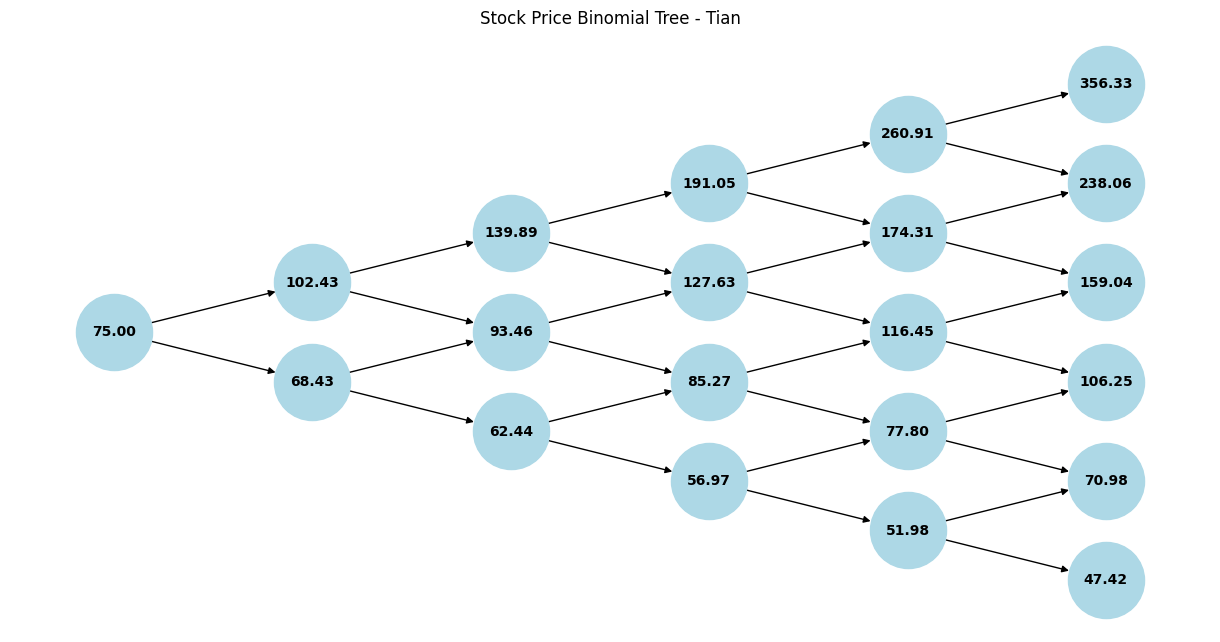

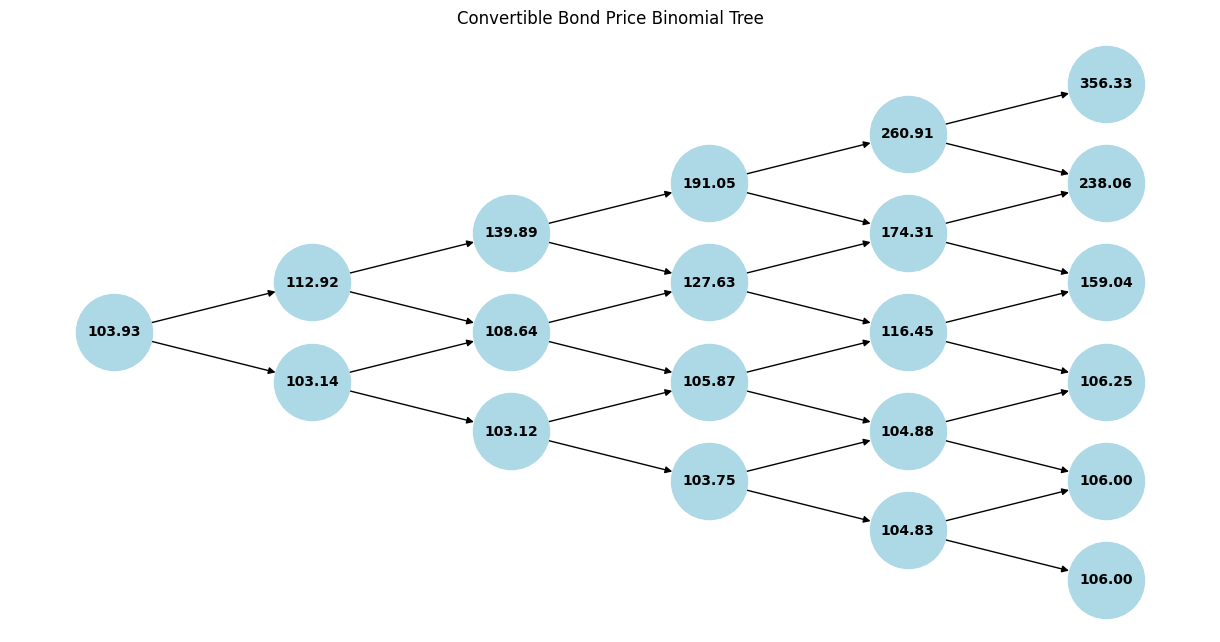

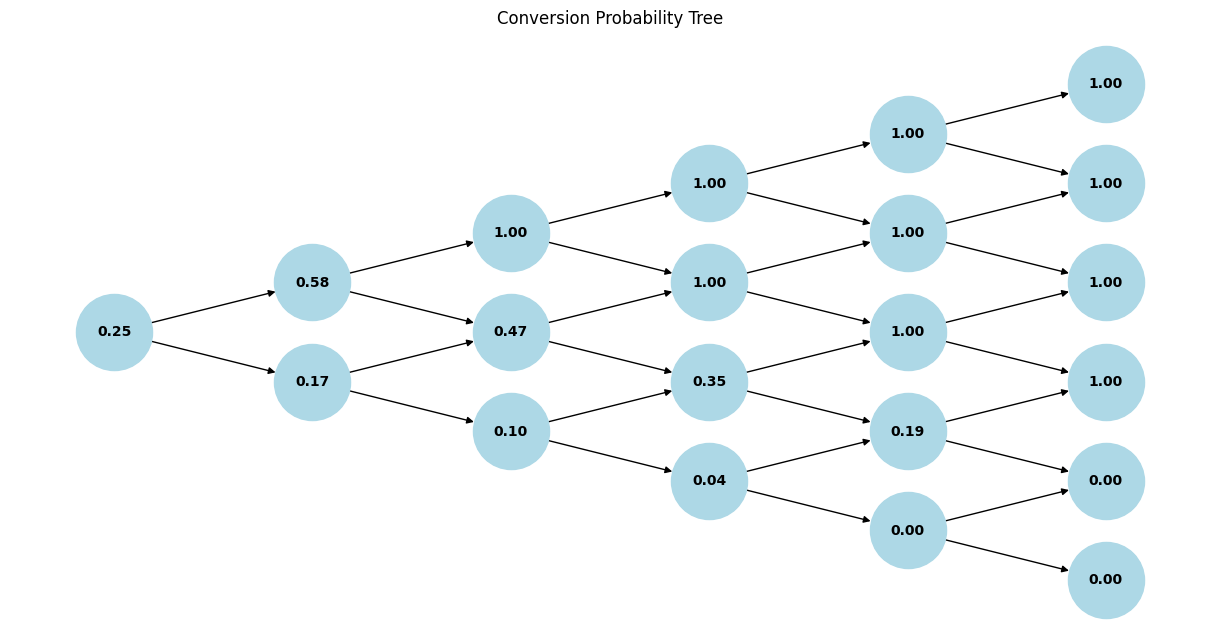

In [74]:
TreeType = 'Tian'

# Calculate the binomial trees using the specified tree type
stock_price_tree, bond_price_tree, conversion_prob_tree = CRR_convertible_bond(S0, F, T, r, k, coupon, m, steps, TreeType)

# Plot the stock price tree
plot_binomial_tree(stock_price_tree, "Stock Price Binomial Tree - Tian")

# Plot the bond price tree
plot_binomial_tree(bond_price_tree, "Convertible Bond Price Binomial Tree")

# Plot the conversion probability tree
plot_binomial_tree(conversion_prob_tree, "Conversion Probability Tree")

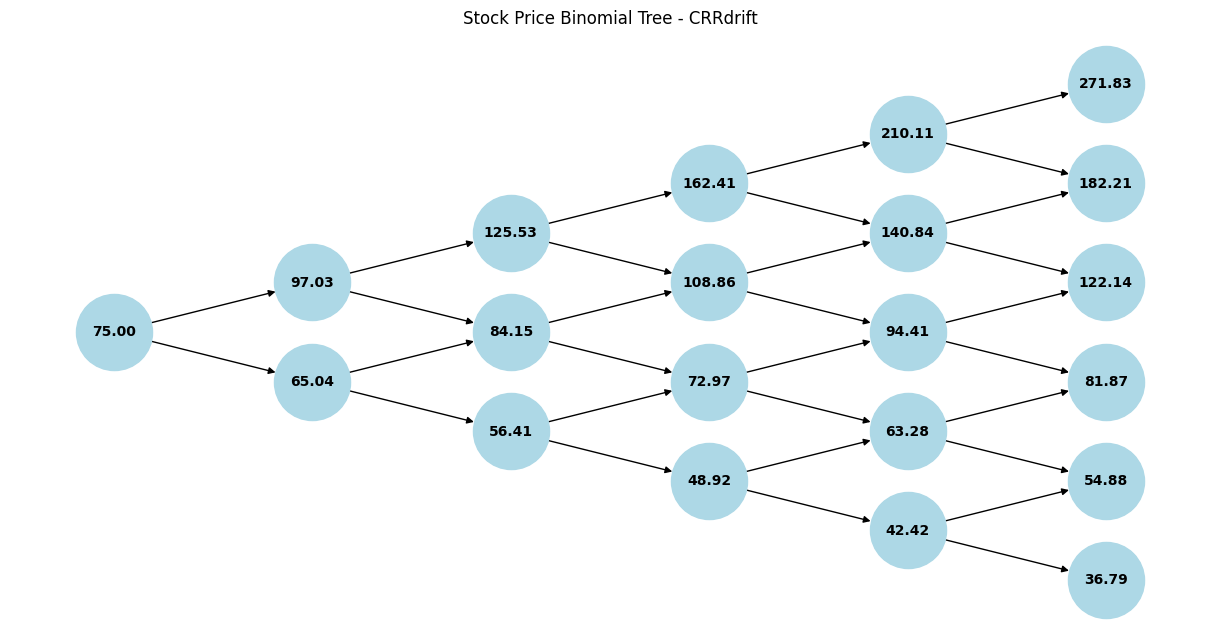

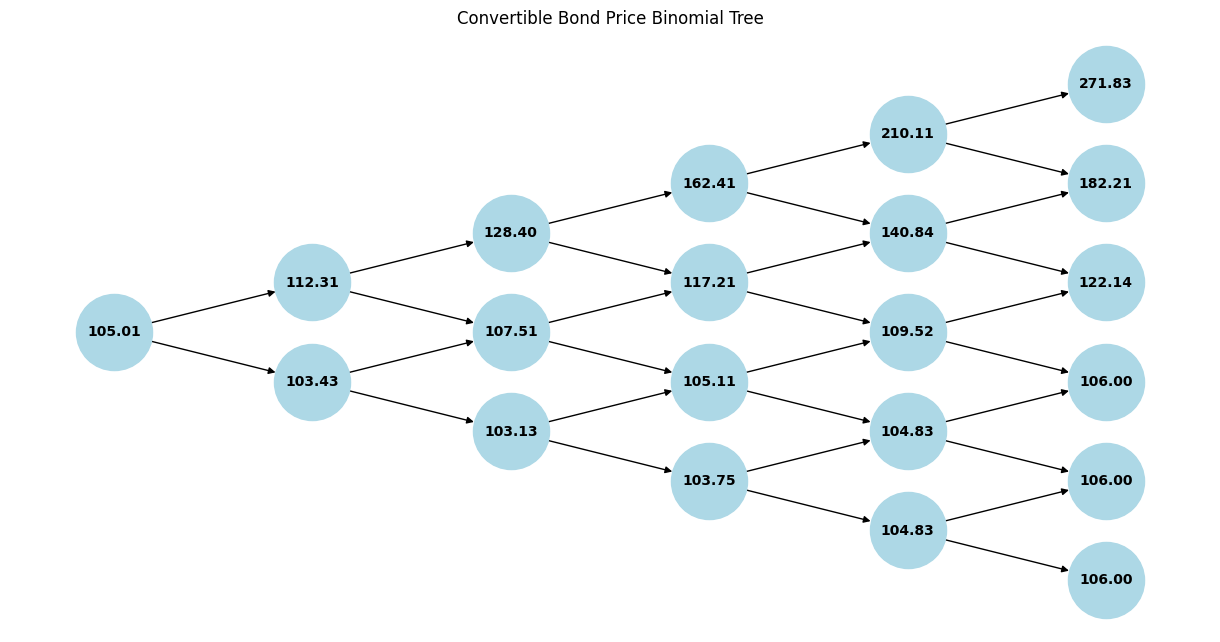

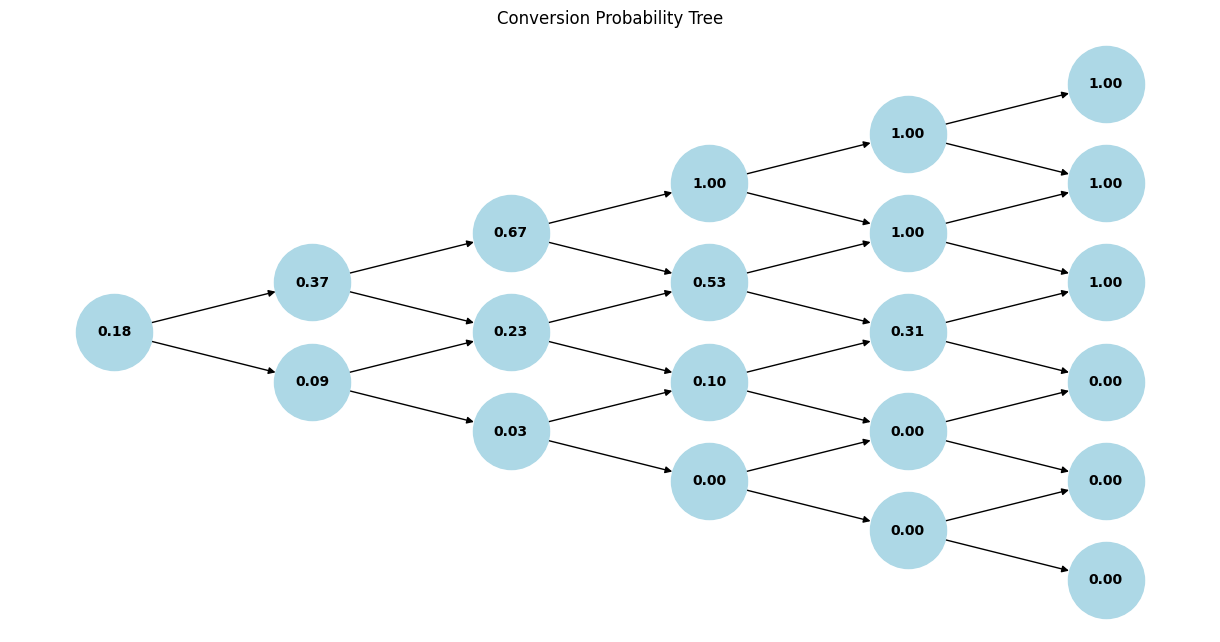

In [75]:
TreeType = 'CRRdrift'

# Calculate the binomial trees using the specified tree type
stock_price_tree, bond_price_tree, conversion_prob_tree = CRR_convertible_bond(S0, F, T, r, k, coupon, m, steps, TreeType)

# Plot the stock price tree
plot_binomial_tree(stock_price_tree, "Stock Price Binomial Tree - CRRdrift")

# Plot the bond price tree
plot_binomial_tree(bond_price_tree, "Convertible Bond Price Binomial Tree")

# Plot the conversion probability tree
plot_binomial_tree(conversion_prob_tree, "Conversion Probability Tree")

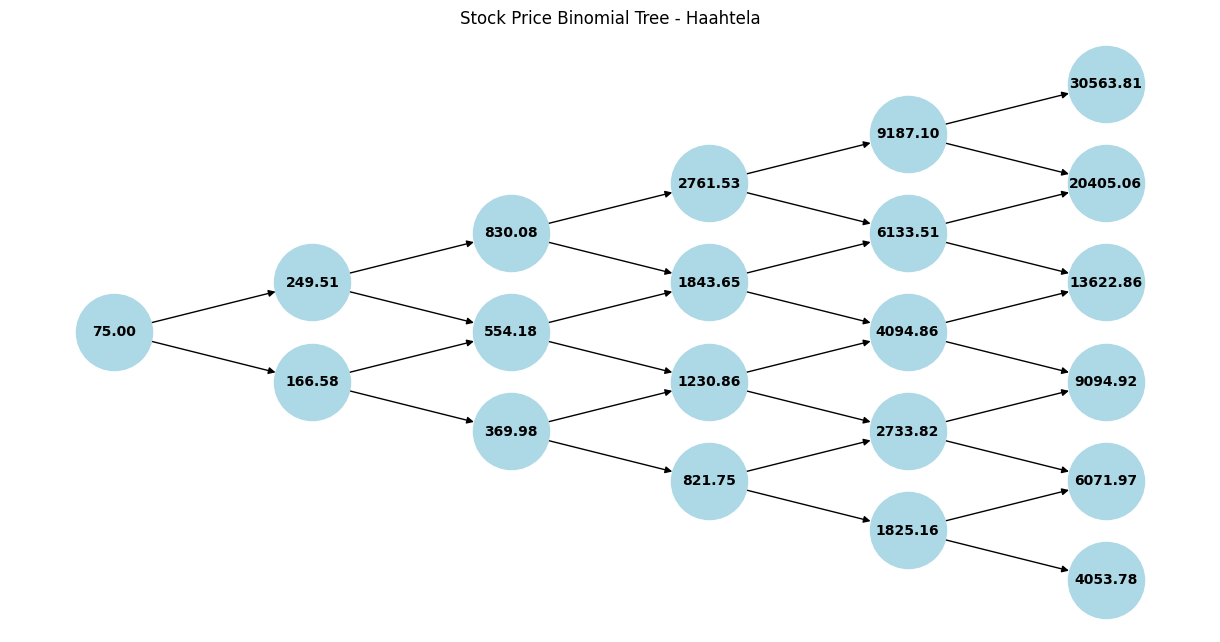

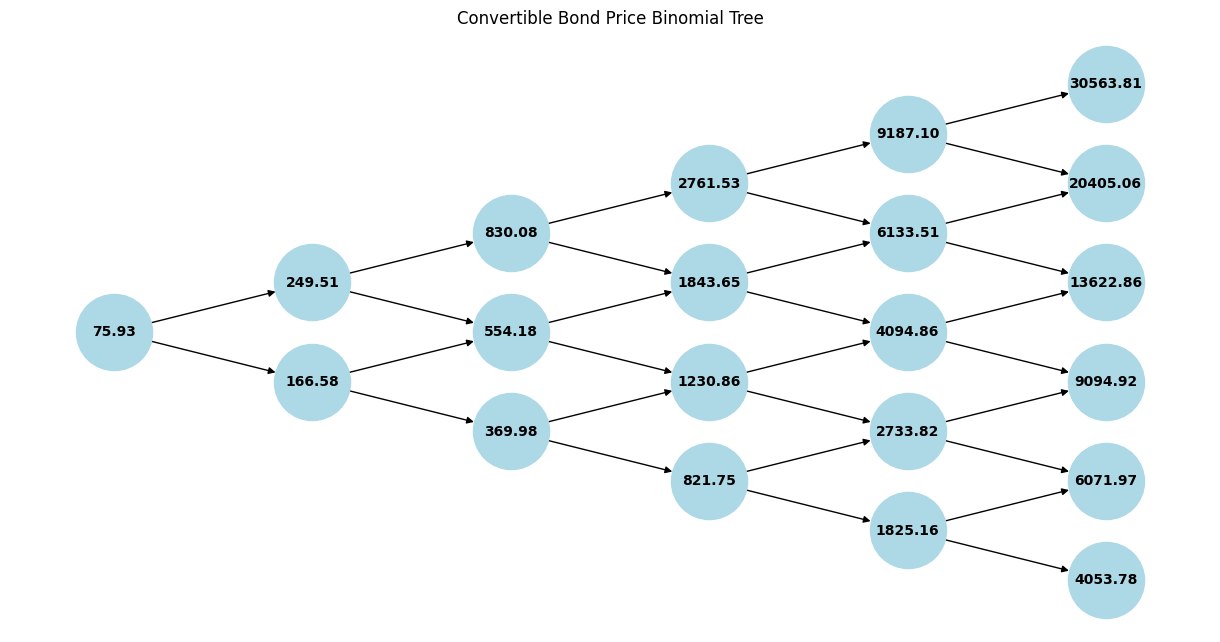

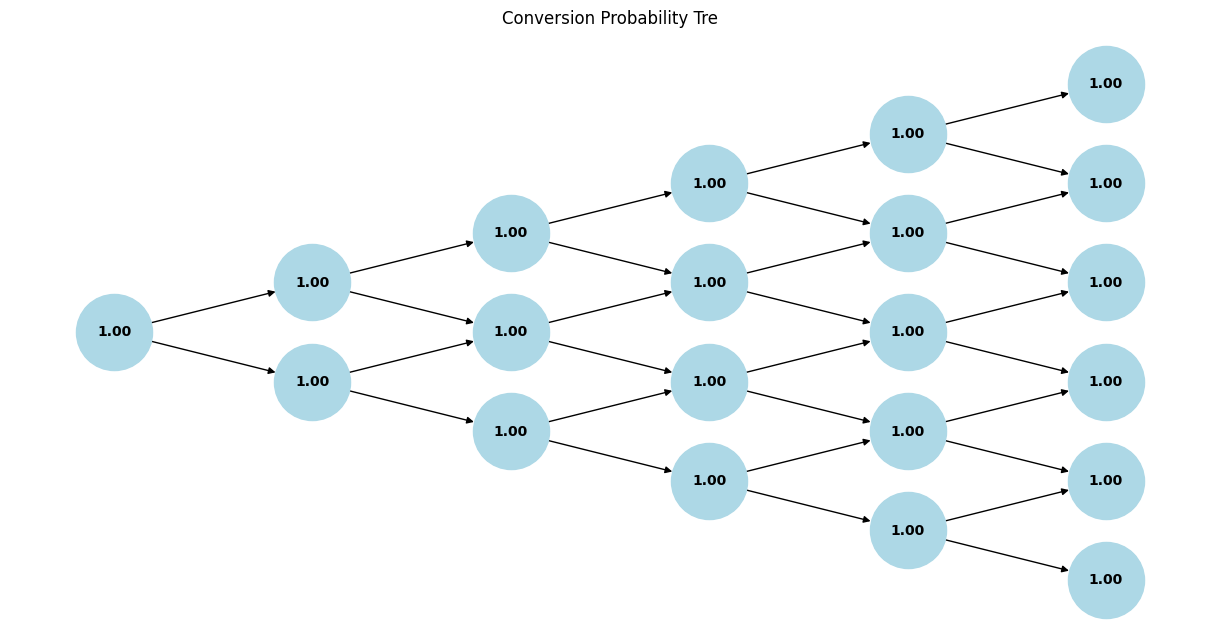

In [76]:
TreeType = 'Haahtela'

# Calculate the binomial trees using the specified tree type
stock_price_tree, bond_price_tree, conversion_prob_tree = CRR_convertible_bond(S0, F, T, r, k, coupon, m, steps, TreeType)

# Plot the stock price tree
plot_binomial_tree(stock_price_tree, "Stock Price Binomial Tree - Haahtela")

# Plot the bond price tree
plot_binomial_tree(bond_price_tree, "Convertible Bond Price Binomial Tree")

# Plot the conversion probability tree
plot_binomial_tree(conversion_prob_tree, "Conversion Probability Tre")

**CONVERGENCE ANALYSIS**

In [77]:
# Calculate bond price using the specific binomial tree model
def calculate_bond_price(S0, F, T, r, sigma, q, coupon, conversion_ratio, steps, model_type, drift=0):
    dt = T / steps
    try:
        u, d, p = calculate_tree_parameters(r, q, sigma, dt, model_type, drift)
    except ValueError as e:
        print(f"Error in model {model_type} with steps = {steps}: {e}")
        return None

    # Stock price tree construction
    StockPrice = np.zeros((steps + 1, steps + 1))
    for i in range(steps + 1):
        for j in range(i + 1):
            StockPrice[j, i] = S0 * (u ** j) * (d ** (i - j))

    # Bond price and conversion probability trees
    BondPrice = np.zeros((steps + 1, steps + 1))
    ConversionProbability = np.zeros((steps + 1, steps + 1))

    # Calculate bond value at maturity
    for i in range(steps + 1):
        BondPrice[i, steps] = max(F + coupon, conversion_ratio * StockPrice[i, steps])
        ConversionProbability[i, steps] = 1 if BondPrice[i, steps] == conversion_ratio * StockPrice[i, steps] else 0

    # Backward induction for bond price and conversion probability
    for j in range(steps - 1, -1, -1):
        for i in range(j + 1):
            # Effective rates depending on conversion probabilities
            ru = ConversionProbability[i + 1, j + 1] * r + (1 - ConversionProbability[i + 1, j + 1]) * (r + drift)
            rd = ConversionProbability[i, j + 1] * r + (1 - ConversionProbability[i, j + 1]) * (r + drift)

            # Calculate bond prices using a smoother weighted average to minimize oscillations
            BondPrice[i, j] = (
                p * BondPrice[i + 1, j + 1] * np.exp(-ru * dt) + 
                (1 - p) * BondPrice[i, j + 1] * np.exp(-rd * dt)
            )

            # Calculate the conversion probabilities using a weighted sum
            ConversionProbability[i, j] = (
                p * ConversionProbability[i + 1, j + 1] + 
                (1 - p) * ConversionProbability[i, j + 1]
            )

    return BondPrice[0, 0]

In [78]:
# Calculate convergence for different models and step sizes
def calculate_convergence(S0, F, T, r, sigma, q, coupon, conversion_ratio, max_steps, model_types, drift=0):
    step_range = range(2, max_steps + 1)
    convergence_results = {model: [] for model in model_types}

    for steps in step_range:
        for model in model_types:
            price = calculate_bond_price(S0, F, T, r, sigma, q, coupon, conversion_ratio, steps, model, drift)
            if price is not None:
                convergence_results[model].append(price)
            else:
                convergence_results[model].append(np.nan)

    return step_range, convergence_results

In [79]:
# Plot the convergence results for each model
def plot_convergence(step_range, convergence_results):
    colors = {
        'CRR': 'orange',
        'Tian': 'magenta',
        'JR': 'blue',
        'CRRdrift': 'lime',
        'Haahtela': 'grey'
    }
    plt.figure(figsize=(15, 8))
    for model, prices in convergence_results.items():
        color = colors.get(model, 'black')  # Default to black if the model is not in the color dictionary
        plt.plot(step_range, prices, label=f"{model} Model",color=color, linewidth=1)
    plt.xlabel("Number of Steps (N)", fontsize=14)
    plt.ylabel("Convertible Bond Price", fontsize=14)
    plt.title("Convergence of Convertible Bond Price for Selected Models", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

In [80]:
# Input parameters for convergence analysis
S0 = 75           # Initial stock price
F = 100           # Face value of the bond
T = 5             # Time to maturity in years
r = 0.07          # Risk-free rate
sigma = 0.2       # Volatility
q = 0             # Dividend yield
coupon = 6        # Annual coupon payment
conversion_ratio = 1  # Conversion ratio
max_steps = 150   # Maximum number of steps for convergence analysis

In [81]:
# Define the models to be tested
model_types = ['CRR', 'Tian', 'JR', 'CRRdrift', 'Haahtela']

# Calculate convergence results
step_range, convergence_results = calculate_convergence(S0, F, T, r, sigma, q, coupon, conversion_ratio, max_steps, model_types)

# Plot the convergence results
plot_convergence(step_range, convergence_results)

NameError: name 'calculate_tree_parameters' is not defined